# 1. Configuración

1. Imports Centralizados

In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torchaudio
import soundfile as sf

import re

from tqdm import tqdm
import transformers
from transformers import AutoModel

/opt/anaconda3/envs/mert310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Se comprueba el entorno Python

In [2]:
sys.executable, sys.version

('/opt/anaconda3/envs/mert310/bin/python',
 '3.10.19 (main, Oct 21 2025, 16:37:10) [Clang 20.1.8 ]')

3. Se comprueban las versiones de las librerías

In [3]:
print("torch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)
print("transformers:", transformers.__version__)
print("soundfile:", sf.__version__)

torch: 2.9.1
torchaudio: 2.9.1
transformers: 4.37.2
soundfile: 0.13.1


4. Paths de lectura de dataset y de escritura de resultados

In [4]:
DATA_ROOT = Path("/Users/dtenreiro/Documents/TFM/EGFxSet")
OUT_DIR   = Path("./outputs_01_panns_base_egfxset")

OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT exists:", DATA_ROOT.exists(), "->", DATA_ROOT)
print("OUT_DIR exists:", OUT_DIR.exists(), "->", OUT_DIR)

DATA_ROOT exists: True -> /Users/dtenreiro/Documents/TFM/EGFxSet
OUT_DIR exists: True -> outputs_01_panns_base_egfxset


5. Dispositivo

In [5]:
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
device

'mps'

6. Información del dispositivo

In [6]:
if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))
elif device == "mps":
    print("Apple Silicon MPS enabled")
else:
    print("CPU only")

Apple Silicon MPS enabled


7. Configuración para calcular inferencia

In [7]:
import time
import numpy as np
import torch

def _sync():
    # Para que el cronómetro mida de verdad en GPU/MPS
    if device == "cuda" and torch.cuda.is_available():
        torch.cuda.synchronize()
    elif device == "mps" and hasattr(torch, "mps"):
        try:
            torch.mps.synchronize()
        except Exception:
            pass

def _summ(times_s, label=""):
    times = np.array(times_s, dtype=np.float64)
    return {
        "label": label,
        "n": int(times.size),
        "mean_ms": float(times.mean() * 1000),
        "p50_ms": float(np.percentile(times, 50) * 1000),
        "p95_ms": float(np.percentile(times, 95) * 1000),
        "min_ms": float(times.min() * 1000),
        "max_ms": float(times.max() * 1000),
        "runs_per_s": float(1.0 / times.mean()),
    }

# 2. Preparación del Dataset EGFxSet

1. Se recorren todos los WAV y se comprueba cuántos hay

In [8]:
# Recorremos todos los WAVs
wav_paths = sorted(DATA_ROOT.rglob("*.wav"))
print("Total: ", len(wav_paths))

Total:  8970


2. Se crean las funciones para recuperar el nombre del tono y la pastilla utilizada

In [9]:
def tone_name(p: Path) -> str:
    # DATA_ROOT/<TONE>/<PICKUP>/<file.wav>
    return p.relative_to(DATA_ROOT).parts[0]

def pickup_name(p: Path) -> str:
    # DATA_ROOT/<TONE>/<PICKUP>/<file.wav>
    return p.relative_to(DATA_ROOT).parts[1]

# sanity check
example = wav_paths[0]
print("Ejemplo:", example)
print("Tono:", tone_name(example))
print("Pastilla:", pickup_name(example))
print("Nombre del fichero:", example.name)


Ejemplo: /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDriver/Bridge/1-0.wav
Tono: BluesDriver
Pastilla: Bridge
Nombre del fichero: 1-0.wav


3. Se construye el DataFrame con metadatos básicos

In [10]:
PAT = re.compile(r"(?P<string>\d+)-(?P<fret>\d+)\.wav$", re.IGNORECASE)

rows = []
for p in tqdm(wav_paths):
    rel = p.relative_to(DATA_ROOT)
    parts = rel.parts

    # Esperado: (tone, pickup, filename)
    if len(parts) < 3:
        continue

    m = PAT.search(p.name)
    if not m:
        continue

    rows.append({
        "path": str(p),
        "tone": parts[0],
        "pickup": parts[1],
        "string": int(m.group("string")),
        "fret": int(m.group("fret")),
    })

df = pd.DataFrame(rows)
df.head(), df.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8970/8970 [00:00<00:00, 280529.30it/s]


(                                                path         tone  pickup  \
 0  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
 1  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
 2  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
 3  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
 4  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
 
    string  fret  
 0       1     0  
 1       1     1  
 2       1    10  
 3       1    11  
 4       1    12  ,
 (8947, 5))

4. Checkeo de datos

In [11]:
print("tones:", df["tone"].nunique(), sorted(df["tone"].unique())[:15])
print("pickups:", df["pickup"].nunique(), sorted(df["pickup"].unique())[:15])
print("strings:", sorted(df["string"].unique()))
print("fret range:", df["fret"].min(), df["fret"].max())

df.groupby(["tone","pickup"]).size().sort_values(ascending=False).head(20)

tones: 13 ['BluesDriver', 'Chorus', 'Clean', 'Digital Delay', 'Flanger', 'Hall Reverb', 'Phaser', 'Plate Reverb', 'RAT', 'Spring Reverb', 'Sweep Echo', 'TapeEcho', 'TubeScreamer']
pickups: 5 ['Bridge', 'Bridge-Middle', 'Middle', 'Middle-Neck', 'Neck']
strings: [1, 2, 3, 4, 5, 6]
fret range: 0 45


tone           pickup       
BluesDriver    Bridge           138
Phaser         Middle-Neck      138
Plate Reverb   Bridge           138
               Bridge-Middle    138
               Middle           138
               Middle-Neck      138
               Neck             138
RAT            Bridge           138
               Bridge-Middle    138
               Middle           138
               Middle-Neck      138
               Neck             138
Spring Reverb  Bridge           138
               Bridge-Middle    138
               Middle           138
               Middle-Neck      138
               Neck             138
Sweep Echo     Bridge           138
               Bridge-Middle    138
               Middle           138
dtype: int64

5. Clase tone_pickup: la combinación tono + pastilla utilizada es lo que queremos diferenciar

In [12]:
df["tone_pickup"] = df["tone"].astype(str) + "__" + df["pickup"].astype(str)

print("tone_pickup classes:", df["tone_pickup"].nunique())
df["tone_pickup"].value_counts().head(20)

tone_pickup classes: 65


tone_pickup
BluesDriver__Bridge             138
Phaser__Middle-Neck             138
Plate Reverb__Bridge            138
Plate Reverb__Bridge-Middle     138
Plate Reverb__Middle            138
Plate Reverb__Middle-Neck       138
Plate Reverb__Neck              138
RAT__Bridge                     138
RAT__Bridge-Middle              138
RAT__Middle                     138
RAT__Middle-Neck                138
RAT__Neck                       138
Spring Reverb__Bridge           138
Spring Reverb__Bridge-Middle    138
Spring Reverb__Middle           138
Spring Reverb__Middle-Neck      138
Spring Reverb__Neck             138
Sweep Echo__Bridge              138
Sweep Echo__Bridge-Middle       138
Sweep Echo__Middle              138
Name: count, dtype: int64

In [13]:
counts = df["tone_pickup"].value_counts()

print("min examples per class:", counts.min())
print("classes with <2 examples:", (counts < 2).sum())

# Si hubiese clases con 1 ejemplo, las eliminamos para el experimento
df_eval = df[df["tone_pickup"].isin(counts[counts >= 2].index)].copy()
print("df_eval shape:", df_eval.shape)

min examples per class: 115
classes with <2 examples: 0
df_eval shape: (8947, 6)


6. Se calcula el pitch. Está afinada en E estándar, por lo que en base a la cuerda y al traste se puede extraer el valor exacto

In [14]:
# Afinación estándar en MIDI por cuerda
# (clave = nº de cuerda tal como viene en el nombre del wav)
OPEN_STRING_MIDI = {
    6: 40,  # E2
    5: 45,  # A2
    4: 50,  # D3
    3: 55,  # G3
    2: 59,  # B3
    1: 64,  # E4
}

def compute_midi_pitch(row):
    return OPEN_STRING_MIDI[row["string"]] + row["fret"]

df["midi_pitch"] = df.apply(compute_midi_pitch, axis=1)

df[["string", "fret", "midi_pitch"]].head(10)

,string,fret,midi_pitch
0,1,0,64
1,1,1,65
2,1,10,74
3,1,11,75
4,1,12,76
5,1,13,77
6,1,14,78
7,1,15,79
8,1,16,80
9,1,17,81


7. Se guardan los metadatos en un .csv

In [15]:
INDEX_COLS = [
    "path",
    "tone",
    "pickup",
    "tone_pickup",
    "string",
    "fret",
    "midi_pitch",
]

index_path = OUT_DIR / "egfxset_index.csv"

df[INDEX_COLS].to_csv(index_path, index=False)

print("Index guardado en:", index_path)
print("Columnas:", INDEX_COLS)
print("Filas:", len(df))

Index guardado en: outputs_01_panns_base_egfxset/egfxset_index.csv
Columnas: ['path', 'tone', 'pickup', 'tone_pickup', 'string', 'fret', 'midi_pitch']
Filas: 8947


# 3. PANNs Baseline

1. Cargar PANNs (Cnn14) + adaptar carga/resample a 32kHz

In [16]:
# Config audio para PANNs CNN14
MAX_SECONDS = 5.0
TARGET_SR = 32000  # <- PANNs CNN14 suele ir a 32k

def load_audio_panns(path: str | Path):
    """Carga wav -> mono -> resample a 32k -> recorta a 5s"""
    wav, sr = sf.read(str(path))

    if wav.ndim == 2:
        wav = wav.mean(axis=1)

    wav = torch.from_numpy(wav).float()

    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        sr = TARGET_SR

    wav = wav[: int(sr * MAX_SECONDS)]
    return wav, sr

def temporal_pool(x: torch.Tensor, mode: str) -> torch.Tensor:
    """
    x: (T, D) ó (B, T, D). Devuelve (D) ó (B, D)
    """
    if x.dim() == 2:
        x0 = x
        if mode == "mean":
            return x0.mean(dim=0)
        elif mode == "max":
            return x0.max(dim=0).values
        elif mode == "stats":
            mu = x0.mean(dim=0)
            sd = x0.std(dim=0, unbiased=False)
            return torch.cat([mu, sd], dim=0)
        else:
            raise ValueError(f"Unknown mode: {mode}")

    if x.dim() == 3:
        if mode == "mean":
            return x.mean(dim=1)
        elif mode == "max":
            return x.max(dim=1).values
        elif mode == "stats":
            mu = x.mean(dim=1)
            sd = x.std(dim=1, unbiased=False)
            return torch.cat([mu, sd], dim=2)
        else:
            raise ValueError(f"Unknown mode: {mode}")

    raise ValueError(f"Unexpected tensor rank: {x.dim()}")

2. Cargar modelo PANNs (Cnn14) + checkpoint

In [17]:
from pathlib import Path
import os
import inspect
import torch
from panns_inference.models import Cnn14

def find_cnn14_ckpt() -> Path:
    # 1) Variable de entorno (si existe)
    env = os.environ.get("PANNS_CNN14_CKPT", "").strip()
    if env:
        p = Path(env).expanduser()
        if p.exists() and p.is_file():
            return p
        raise FileNotFoundError(f"PANNS_CNN14_CKPT apunta a algo que no es fichero: {p}")

    # 2) Buscar dentro del paquete instalado (rutas típicas)
    pkg_root = Path(inspect.getfile(Cnn14)).resolve().parent  # .../panns_inference/models
    candidates = []
    for rel in [
        "../pretrained_models",
        "../pretrained",
        "../data",
        "../../pretrained_models",
        "../../pretrained",
    ]:
        d = (pkg_root / rel).resolve()
        if d.exists() and d.is_dir():
            candidates += list(d.rglob("*.pth"))

    # 3) Heurística: prioriza CNN14 si aparece en el nombre
    candidates = sorted(candidates, key=lambda p: (("cnn14" not in p.name.lower()), len(p.name)))
    if candidates:
        return candidates[0]

    raise FileNotFoundError(
        "No encuentro ningún checkpoint .pth de PANNs CNN14.\n"
        "Opciones:\n"
        "  - Descarga el checkpoint y pon PANNS_CNN14_CKPT=/ruta/al/Cnn14.pth\n"
        "  - O copia el .pth en una carpeta tipo .../panns_inference/pretrained_models/\n"
    )

CKPT = find_cnn14_ckpt()
print("Using checkpoint:", CKPT)

panns_model = Cnn14(
    sample_rate=TARGET_SR,
    window_size=1024,
    hop_size=320,
    mel_bins=64,
    fmin=50,
    fmax=14000,
    classes_num=527
)

ckpt = torch.load(CKPT, map_location=device)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
panns_model.load_state_dict(state, strict=True)

panns_model.to(device).eval()
print("Loaded PANNs:", panns_model.__class__.__name__, "on", device)

Using checkpoint: /Users/dtenreiro/Documents/TFM/panns_inference/pretrained_models/Cnn14_mAP=0.431.pth
Loaded PANNs: Cnn14 on mps


In [18]:
import inspect
from panns_inference.models import Cnn14
from pathlib import Path

pkg_root = Path(inspect.getfile(Cnn14)).resolve().parent
pkg_root, list((pkg_root/"../pretrained_models").resolve().glob("**/*.pth"))[:5]

(PosixPath('/Users/dtenreiro/Documents/TFM/panns_inference/panns_inference'),
 [PosixPath('/Users/dtenreiro/Documents/TFM/panns_inference/pretrained_models/Cnn14_mAP=0.431.pth')])

3. Extracción de embeddings PANNs (global + poolings temporales)

In [19]:
def extract_panns_variants(path):
    """
    Devuelve dict {variant: embedding_1D_cpu}
    """
    x, sr = load_audio_panns(path)
    x = x.to(device).unsqueeze(0)  # (1, n)

    with torch.no_grad():
        out = panns_model(x, None)

    variants = {}

    # Embedding global (siempre existe)
    g = out["embedding"].squeeze(0).float().cpu()
    variants["global"] = g

    # Framewise (si existe)
    frame = None
    if "framewise_embedding" in out:
        frame = out["framewise_embedding"]  # (B, T, D)
    elif "framewise_output" in out:
        frame = out["framewise_output"]     # (B, T, D) o (B, T, C)

    if frame is not None:
        frame = frame.squeeze(0).float().cpu()  # (T, D)
        variants["frame_mean"]  = temporal_pool(frame, "mean")
        variants["frame_max"]   = temporal_pool(frame, "max")
        variants["frame_stats"] = temporal_pool(frame, "stats")

    return variants


# --- Sondeo de variantes y dimensiones ---
paths = df["path"].tolist()
N = len(paths)

test_vars = extract_panns_variants(paths[0])
dims = {k: v.numel() for k, v in test_vars.items()}
dims

{'global': 2048}

4. benchmark end-to-end

In [20]:
# --- Benchmark end-to-end: load + resample + forward + cpu + pooling ---
paths_bench = df["path"].tolist()

n_warmup = 10
n_runs = 50  # sube si quieres más estabilidad

# warmup (sin medir)
for p in paths_bench[:n_warmup]:
    _ = extract_panns_variants(p)

times = []
for p in paths_bench[:n_runs]:
    _sync()
    t0 = time.perf_counter()
    _ = extract_panns_variants(p)
    _sync()
    t1 = time.perf_counter()
    times.append(t1 - t0)

stats_e2e = _summ(times, label="E2E extract_panns_variants (I/O+resample+forward+pool)")
stats_e2e

{'label': 'E2E extract_panns_variants (I/O+resample+forward+pool)',
 'n': 50,
 'mean_ms': 7.797768280070159,
 'p50_ms': 7.634874999894237,
 'p95_ms': 8.700914250130154,
 'min_ms': 7.003833999988274,
 'max_ms': 10.863457999221282,
 'runs_per_s': 128.24182049059334}

5. Benchmark forward puro

In [21]:
# Prepara 1 waveform ya en device, evitando sf.read + resample cada vez
p0 = df["path"].iloc[0]
wav, sr = load_audio_panns(p0)        # incluye resample una vez
x = wav.to(device).unsqueeze(0)       # (1, n)

panns_model.eval()

n_warmup = 30
n_runs = 200

with torch.inference_mode():
    # warmup
    for _ in range(n_warmup):
        _ = panns_model(x, None)
    _sync()

    times = []
    for _ in range(n_runs):
        _sync()
        t0 = time.perf_counter()
        _ = panns_model(x, None)
        _sync()
        t1 = time.perf_counter()
        times.append(t1 - t0)

stats_forward = _summ(times, label="FORWARD ONLY panns_model(x)")
stats_forward

{'label': 'FORWARD ONLY panns_model(x)',
 'n': 200,
 'mean_ms': 4.3697810099729395,
 'p50_ms': 4.303020999941509,
 'p95_ms': 4.681907700614829,
 'min_ms': 4.199249999146559,
 'max_ms': 4.878792000454268,
 'runs_per_s': 228.84441982738915}

5. Pre-alloc y extracción masiva de embeddings PANNs

In [22]:
# --- Pre-alloc y extracción masiva de embeddings PANNs ---

from tqdm import tqdm

# Crear memmaps en disco (uno por variante)
out_memmaps = {}
for variant, dim in dims.items():
    out_path = OUT_DIR / f"embeddings_panns_{variant}.npy"
    mm = np.memmap(
        out_path,
        dtype=np.float32,
        mode="w+",
        shape=(N, dim)
    )
    out_memmaps[variant] = (mm, out_path)

# Guardar primer embedding (ya calculado)
for variant, vec in test_vars.items():
    out_memmaps[variant][0][0] = vec.numpy().astype(np.float32)

# Loop principal
for i, path in enumerate(tqdm(paths[1:], desc="Extracting PANNs embeddings"), start=1):
    vars_i = extract_panns_variants(path)

    for variant in dims.keys():
        # Fallback: si alguna variante no existe para este audio, usar global
        vec = vars_i.get(variant, vars_i["global"])
        out_memmaps[variant][0][i] = vec.numpy().astype(np.float32)

# Flush explícito a disco
for variant, (mm, out_path) in out_memmaps.items():
    mm.flush()
    print(f"Saved {out_path.name}  shape={mm.shape}")

Extracting PANNs embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8946/8946 [01:05<00:00, 135.75it/s]

Saved embeddings_panns_global.npy  shape=(8947, 2048)


CNN14 ya viene globalmente pooled por diseño.

# 4. Evaluación

In [35]:
from pathlib import Path
import matplotlib.pyplot as plt

# Carpeta donde guardar figuras
FIG_DIR = OUT_DIR / "figures_mert"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, dpi=300):
    """
    Guarda la figura en FIG_DIR con nombre 'name'. Añade .png si no lo lleva.
    """
    name = name if name.lower().endswith(".png") else f"{name}.png"
    out = OUT_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved:", out)

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path

def l2_normalize(X: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

labels = df["tone_pickup"].astype(str).to_numpy()
N = len(labels)

emb_files = sorted(OUT_DIR.glob("embeddings_panns_*.npy"))
print("Found embedding files:", len(emb_files))

results = []

for f in emb_files:
    X = np.memmap(f, dtype=np.float32, mode="r")
    X = X.reshape(len(df), -1)
    X = l2_normalize(X)


    # Similaridad coseno = X @ X.T
    S = X @ X.T
    np.fill_diagonal(S, -np.inf)

    # Top-1
    nn1 = np.argmax(S, axis=1)
    top1 = (labels[nn1] == labels).mean()

    # Top-5
    nn5 = np.argpartition(-S, kth=5, axis=1)[:, :5]
    top5 = np.array([labels[i] in labels[nn5[r]] for r, i in enumerate(range(N))]).mean()

    results.append({
        "file": f.name,
        "dim": X.shape[1],
        "top1": float(top1),
        "top5": float(top5),
    })

res_df = pd.DataFrame(results).sort_values(["top1", "top5"], ascending=False)
res_df.head(20)

Found embedding files: 1


,file,dim,top1,top5
0,embeddings_panns_global.npy,2048,0.50855,0.865206


In [24]:
# Añadimos baseline de azar
N_CLASSES = df["tone_pickup"].nunique()
chance = 1.0 / N_CLASSES

res_df_eval = res_df.copy()
res_df_eval["chance"] = chance
res_df_eval["top1_vs_chance"] = res_df_eval["top1"] / chance

res_df_eval = res_df_eval.sort_values(
    ["top1", "top5"], ascending=False
)

res_df_eval.head(10)

,file,dim,top1,top5,chance,top1_vs_chance
0,embeddings_panns_global.npy,2048,0.50855,0.865206,0.015385,33.055773


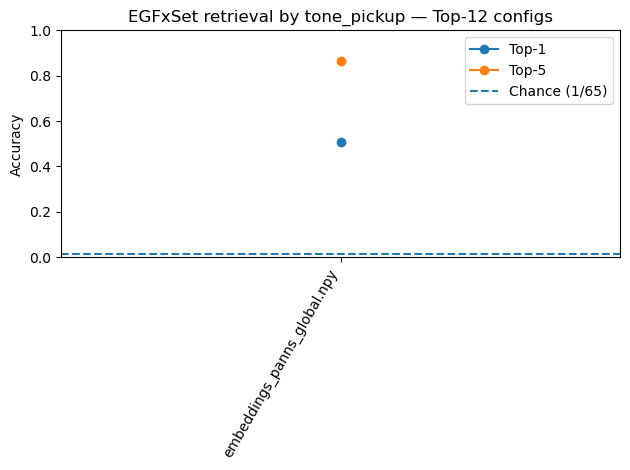

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Top-N configuraciones a mostrar
TOPN = 12

# Si no tienes res_df_eval, usa tu res_df y calcula chance aparte
plot_df = res_df_eval.sort_values(["top1", "top5"], ascending=False).head(TOPN).copy()

x = np.arange(len(plot_df))
labels = plot_df["file"].tolist()

plt.figure()
plt.plot(x, plot_df["top1"].to_numpy(), marker="o", label="Top-1")
plt.plot(x, plot_df["top5"].to_numpy(), marker="o", label="Top-5")

# Línea de azar (Top-1)
chance = float(plot_df["chance"].iloc[0])
plt.axhline(chance, linestyle="--", label=f"Chance (1/{int(round(1/chance))})")

plt.xticks(x, labels, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.title(f"EGFxSet retrieval by tone_pickup — Top-{TOPN} configs")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

Best embedding: embeddings_panns_global.npy


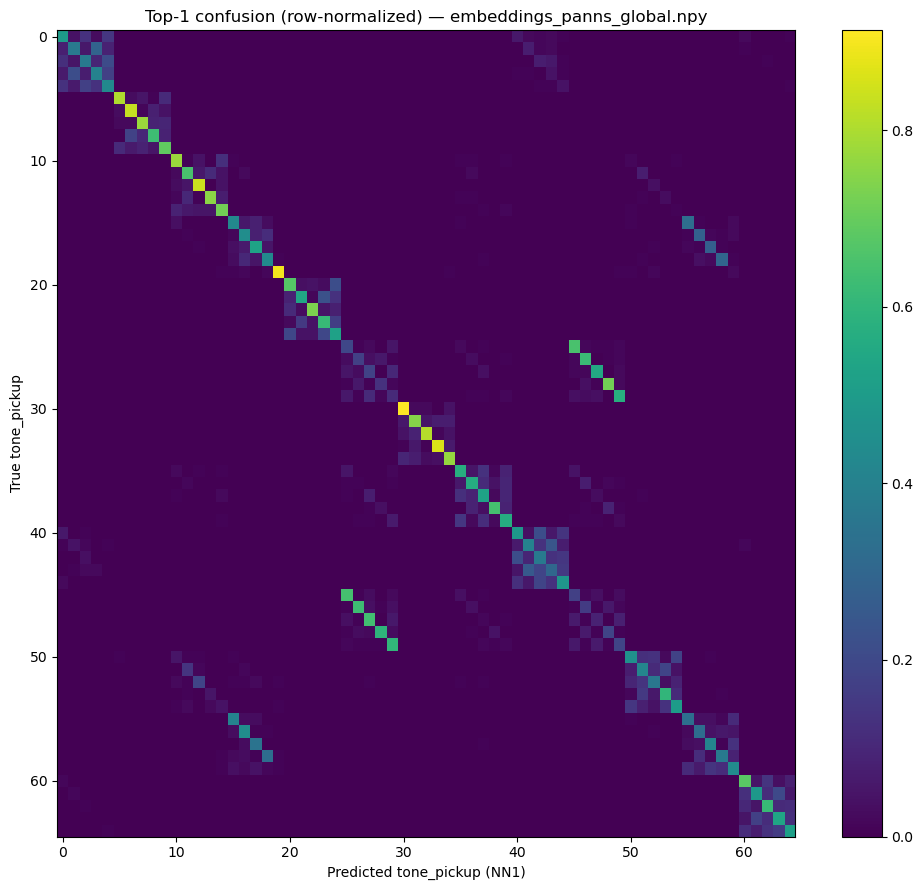

row_0                         col_0                       
Hall Reverb__Middle-Neck      Spring Reverb__Middle-Neck      99
Hall Reverb__Bridge           Spring Reverb__Bridge           90
Spring Reverb__Bridge         Hall Reverb__Bridge             89
Spring Reverb__Middle         Hall Reverb__Middle             88
Spring Reverb__Bridge-Middle  Hall Reverb__Bridge-Middle      87
Hall Reverb__Bridge-Middle    Spring Reverb__Bridge-Middle    86
Spring Reverb__Neck           Hall Reverb__Neck               83
Spring Reverb__Middle-Neck    Hall Reverb__Middle-Neck        82
Hall Reverb__Neck             Spring Reverb__Neck             79
Hall Reverb__Middle           Spring Reverb__Middle           76
TapeEcho__Bridge-Middle       Digital Delay__Bridge-Middle    62
TapeEcho__Bridge              Digital Delay__Bridge           56
TapeEcho__Middle              Digital Delay__Middle           48
Digital Delay__Bridge         TapeEcho__Bridge                45
TapeEcho__Middle-Neck         D

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Elegimos el mejor fichero según Top-1
best_file = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]["file"]
best_path = OUT_DIR / best_file
print("Best embedding:", best_file)

# 2) Cargamos embeddings y labels
X = np.memmap(best_path, dtype=np.float32, mode="r")
X = X.reshape(len(df), -1)
labels = df["tone_pickup"].astype(str).to_numpy()
assert X.shape[0] == len(labels), f"Mismatch: X has {X.shape[0]} rows, labels has {len(labels)}"

# 3) Normalizamos y calculamos vecino Top-1
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
S = X @ X.T
np.fill_diagonal(S, -np.inf)
nn1 = np.argmax(S, axis=1)

y_true = labels
y_pred = labels[nn1]

# 4) Matriz de confusión (conteos) y normalización por fila
cm = pd.crosstab(y_true, y_pred)  # filas: true, columnas: pred
cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns), fill_value=0)
cm_norm = cm.div(cm.sum(axis=1).replace(0, 1), axis=0)  # por fila

# 5) Plot
plt.figure(figsize=(10, 9))
plt.imshow(cm_norm.to_numpy(), aspect="auto")
plt.title(f"Top-1 confusion (row-normalized) — {best_file}")
plt.xlabel("Predicted tone_pickup (NN1)")
plt.ylabel("True tone_pickup")
plt.colorbar()
plt.tight_layout()
plt.show()

# (opcional) ver las confusiones más frecuentes (sin diagonal)
cm_off = cm.copy()
for k in cm_off.index:
    if k in cm_off.columns:
        cm_off.loc[k, k] = 0

top_conf = (
    cm_off.stack()
    .sort_values(ascending=False)
    .head(20)
)
top_conf

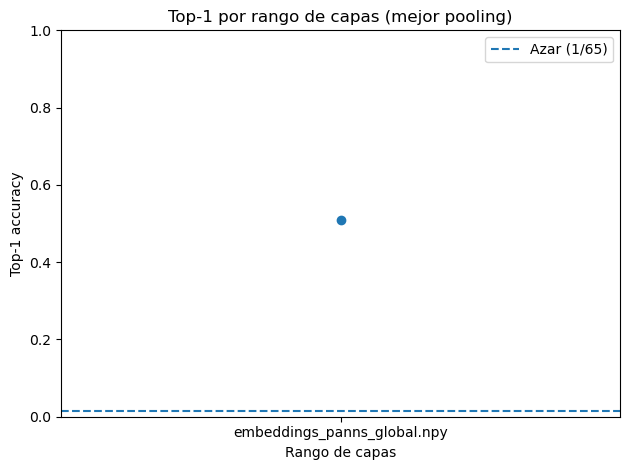

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Partimos del res_df_eval que ya tienes
df_plot = res_df_eval.copy()

# Extraemos el rango de capas del nombre del fichero
def get_layer_group(fname):
    if "__" in fname:
        return fname.split("__")[0].replace("embeddings_", "")
    return fname

df_plot["layer_group"] = df_plot["file"].apply(get_layer_group)

# Para cada grupo de capas, cogemos el MEJOR Top-1
agg = (
    df_plot
    .groupby("layer_group")["top1"]
    .max()
    .sort_values(ascending=False)
)

plt.figure()
plt.plot(agg.index, agg.values, marker="o")
plt.axhline(df_plot["chance"].iloc[0], linestyle="--", label="Azar (1/65)")
plt.ylabel("Top-1 accuracy")
plt.xlabel("Rango de capas")
plt.title("Top-1 por rango de capas (mejor pooling)")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

Best embedding: embeddings_panns_global.npy
Top-1 tone_pickup: 0.5085503520733207 chance: 0.015384615384615385
Top-1 tone only   : 0.7973622443277076 chance: 0.07692307692307693


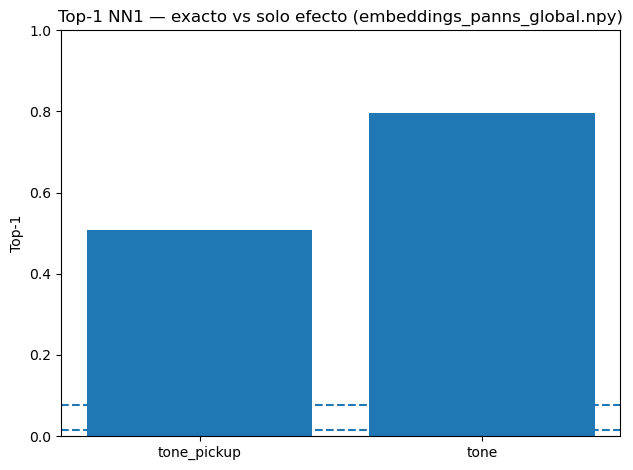

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def l2_normalize(X: np.ndarray, eps: float = 1e-9) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    return X / (n + eps)

# Mejor config por Top-1 (puedes fijarlo a mano si quieres)
best_file = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]["file"]
best_path = OUT_DIR / best_file
print("Best embedding:", best_file)

X = np.memmap(best_path, dtype=np.float32, mode="r")
X = X.reshape(len(df), -1)
labels_tp = df["tone_pickup"].astype(str).to_numpy()
labels_tone = df["tone"].astype(str).to_numpy()

assert X.shape[0] == len(labels_tp)

X = l2_normalize(X)
S = X @ X.T
np.fill_diagonal(S, -np.inf)
nn1 = np.argmax(S, axis=1)

# Top-1 exacto (tone+pickup)
top1_tone_pickup = float((labels_tp[nn1] == labels_tp).mean())

# Top-1 solo por efecto (tone)
top1_tone = float((labels_tone[nn1] == labels_tone).mean())

chance_tone_pickup = 1.0 / df["tone_pickup"].nunique()
chance_tone = 1.0 / df["tone"].nunique()

print("Top-1 tone_pickup:", top1_tone_pickup, "chance:", chance_tone_pickup)
print("Top-1 tone only   :", top1_tone, "chance:", chance_tone)

# Plot simple comparativo
plt.figure()
plt.bar(["tone_pickup", "tone"], [top1_tone_pickup, top1_tone])
plt.axhline(chance_tone_pickup, linestyle="--")
plt.axhline(chance_tone, linestyle="--")
plt.ylabel("Top-1")
plt.title(f"Top-1 NN1 — exacto vs solo efecto ({best_file})")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

In [29]:
tabla = res_df_eval.copy()

tabla["Configuración"] = tabla["file"]
tabla["Modelo"] = "PANNs CNN14"
tabla["Capas usadas"] = "Global (interno)"
tabla["Pooling de capas"] = "Global pooling (modelo)"
tabla["Dimensión"] = tabla["dim"]
tabla["Top-1"] = tabla["top1"].round(3)
tabla["Top-5"] = tabla["top5"].round(3)
tabla["Veces mejor que azar"] = tabla["top1_vs_chance"].round(1)

tabla_final = tabla[
    ["Configuración", "Modelo", "Capas usadas", "Pooling de capas",
     "Dimensión", "Top-1", "Top-5", "Veces mejor que azar"]
].sort_values("Top-1", ascending=False)

tabla_final

,Configuración,Modelo,Capas usadas,Pooling de capas,Dimensión,Top-1,Top-5,Veces mejor que azar
0,embeddings_panns_global.npy,PANNs CNN14,Global (interno),Global pooling (modelo),2048,0.509,0.865,33.1


Usando best_file: embeddings_panns_global.npy | top1=0.5086 | top5=0.8652


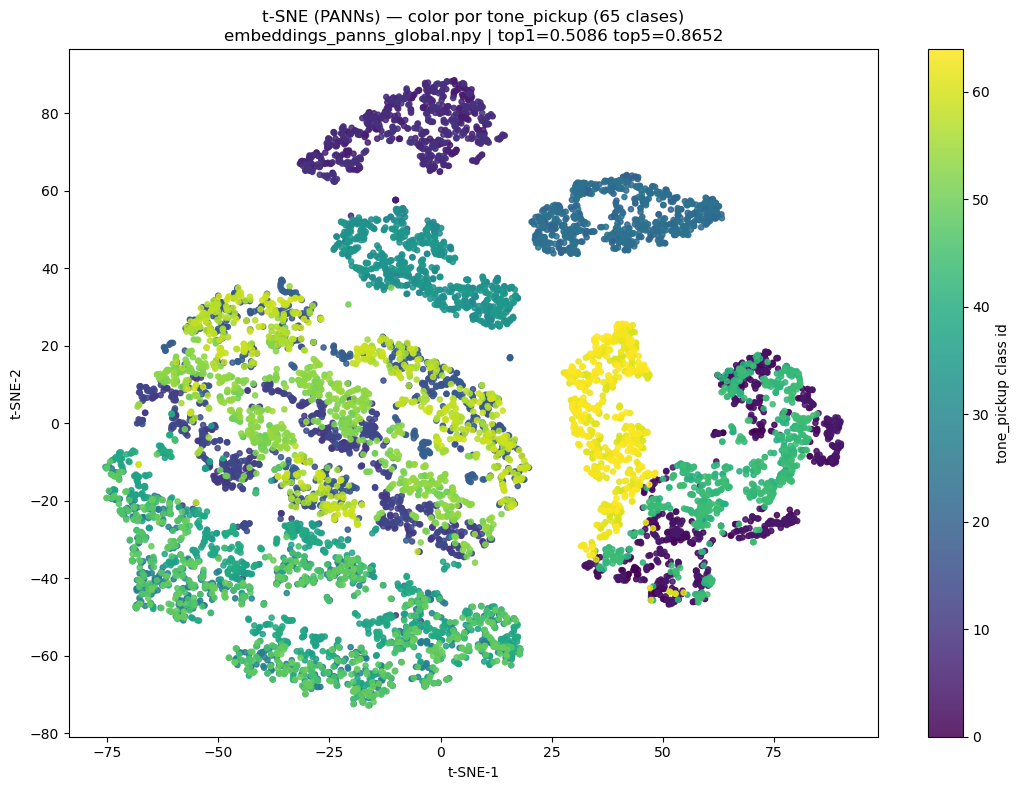

Saved: outputs_01_panns_base_egfxset/mert_tsne_global_tone_pickup_embeddings_panns_global.png


In [36]:
# --- t-SNE (PANNs) SOLO por tone_pickup usando el mejor embedding+pooling ---
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1) Selecciona el MEJOR embedding+pooling según tu evaluación (top1, luego top5)
best_row = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]
best_file = best_row["file"]
best_top1 = best_row["top1"]
best_top5 = best_row["top5"]

best_path = OUT_DIR / best_file
print(f"Usando best_file: {best_file} | top1={best_top1:.4f} | top5={best_top5:.4f}")

# 2) Carga embeddings (PANNs suele guardarlo como memmap en tu notebook)
X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
assert X.shape[0] == len(df), f"X filas ({X.shape[0]}) != df filas ({len(df)})"

labels = df["tone_pickup"].astype(str).to_numpy()

# 3) Normaliza
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

# 4) PCA previo
pca_dim = min(50, X.shape[1])
X_pca = PCA(n_components=pca_dim, random_state=42).fit_transform(X)

# 5) t-SNE
N = X_pca.shape[0]
perplexity = max(5, min(30, (N - 1) // 3))

tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="pca",
    learning_rate="auto",
    random_state=42,
)
Z = tsne.fit_transform(X_pca)

# 6) Plot (65 clases -> sin leyenda)
uniq = sorted(set(labels.tolist()))
lab2i = {u:i for i,u in enumerate(uniq)}
c = np.array([lab2i[x] for x in labels], dtype=int)

plt.figure(figsize=(11, 8))
plt.scatter(Z[:, 0], Z[:, 1], c=c, s=14, alpha=0.85)
plt.title(f"t-SNE (PANNs) — color por tone_pickup (65 clases)\n{best_file} | top1={best_top1:.4f} top5={best_top5:.4f}")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
cb = plt.colorbar()
cb.set_label("tone_pickup class id")
plt.tight_layout()
plt.show()

savefig(plt.gcf(), f"mert_tsne_global_tone_pickup_{Path(best_file).stem}")
plt.close(plt.gcf())

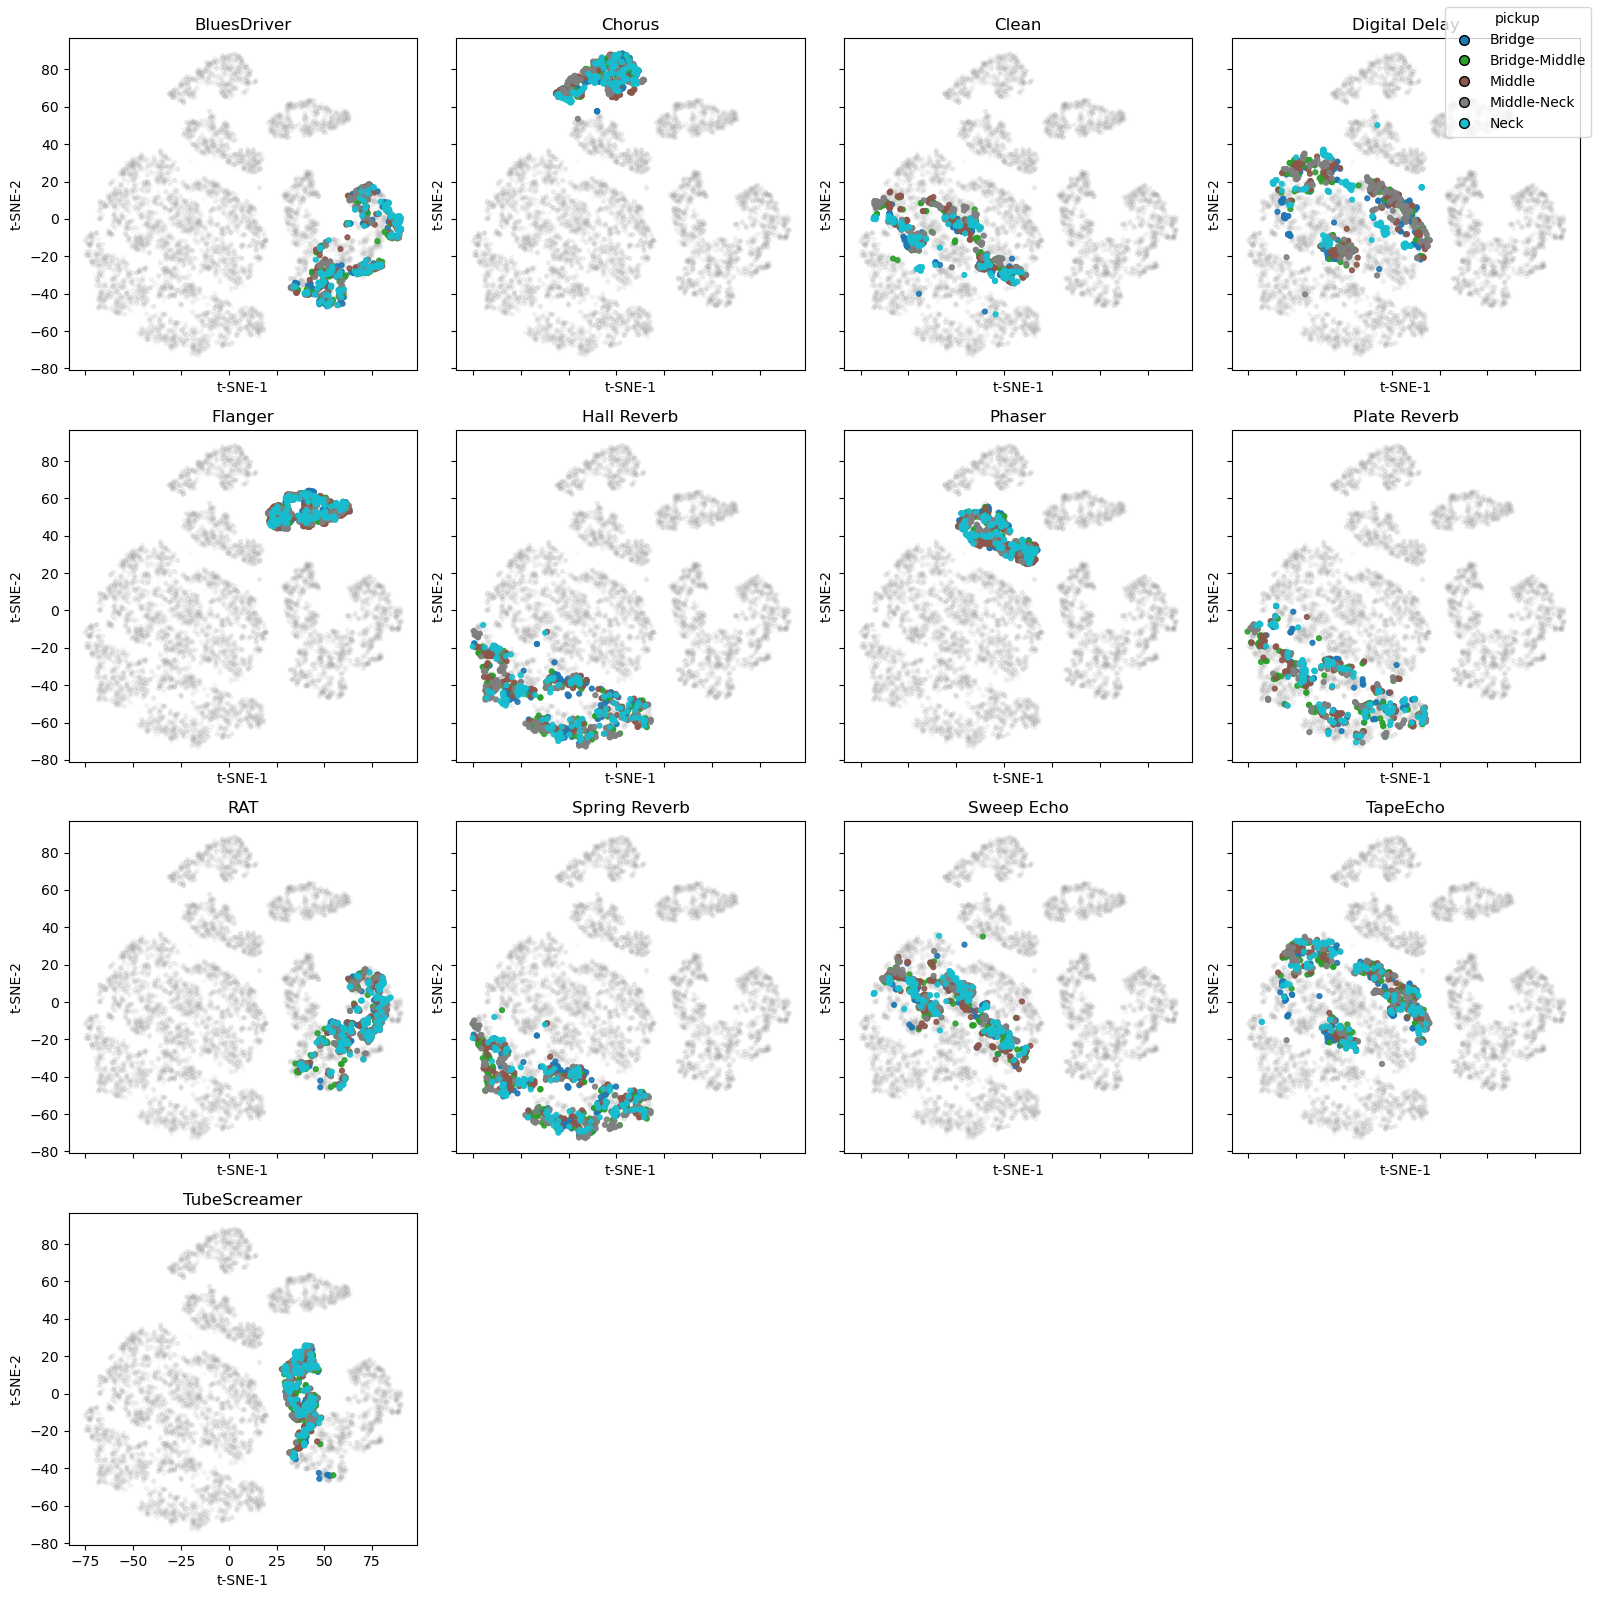

Saved: outputs_01_panns_base_egfxset/panns_tsne_subplots_by_tone_color_pickup_embeddings_panns_global.png


In [38]:
# --- Subplots por tone, coloreando por pickup (leyenda correcta) ---
import numpy as np
import matplotlib.pyplot as plt

tones = sorted(df["tone"].astype(str).unique())
pickups = sorted(df["pickup"].astype(str).unique())

# Mapeo pickup -> id
p2i = {p:i for i,p in enumerate(pickups)}
pickup_ids = df["pickup"].astype(str).map(p2i).to_numpy()

# Colormap discreto (5 pickups)
cmap = plt.get_cmap("tab10", len(pickups))

# Grid
n = len(tones)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(16, 4*nrows),
    sharex=True,
    sharey=True
)
axes = np.array(axes).reshape(-1)

for ax, t in zip(axes, tones):
    m = (df["tone"].astype(str).to_numpy() == t)

    # Fondo gris (contexto)
    ax.scatter(
        Z[~m, 0], Z[~m, 1],
        s=8, alpha=0.03, color="grey"
    )

    # Puntos del tono actual, coloreados por pickup
    ax.scatter(
        Z[m, 0], Z[m, 1],
        c=pickup_ids[m],
        cmap=cmap,
        s=12,
        alpha=0.9,
        vmin=0,
        vmax=len(pickups)-1
    )

    ax.set_title(t)
    ax.set_xlabel("t-SNE-1")
    ax.set_ylabel("t-SNE-2")

# Apagar ejes sobrantes
for k in range(len(tones), len(axes)):
    axes[k].axis("off")

# --- Leyenda CORRECTA ---
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=7,
        markerfacecolor=cmap(i),
        markeredgecolor='black',
        label=p
    )
    for p, i in p2i.items()
]

fig.legend(
    handles=handles,
    title="pickup",
    loc="upper right"
)

plt.tight_layout()
plt.show()

savefig(fig, f"panns_tsne_subplots_by_tone_color_pickup_{Path(best_file).stem}")
plt.close(fig)

In [31]:
# --- Tabla de métricas de inferencia (PANNs) ---
import pandas as pd

rows = []
for d in [stats_e2e, stats_forward]:
    rows.append({
        "model": "PANNs",
        "variant": d.get("label", ""),
        "device": device,
        "n_runs": d.get("n", None),
        "mean_ms": d.get("mean_ms", None),
        "p50_ms": d.get("p50_ms", None),
        "p95_ms": d.get("p95_ms", None),
        "min_ms": d.get("min_ms", None),
        "max_ms": d.get("max_ms", None),
        "runs_per_s": d.get("runs_per_s", None),
    })

infer_panns_df = pd.DataFrame(rows).sort_values(["model", "variant"])
infer_panns_df


,model,variant,device,n_runs,mean_ms,p50_ms,p95_ms,min_ms,max_ms,runs_per_s
0,PANNs,E2E extract_panns_variants (I/O+resample+forwa...,mps,50,7.797768,7.634875,8.700914,7.003834,10.863458,128.24182
1,PANNs,FORWARD ONLY panns_model(x),mps,200,4.369781,4.303021,4.681908,4.199250,4.878792,228.84442


Best: embeddings_panns_global.npy | top1= 0.5085503520733207 top5= 0.8652062143735331


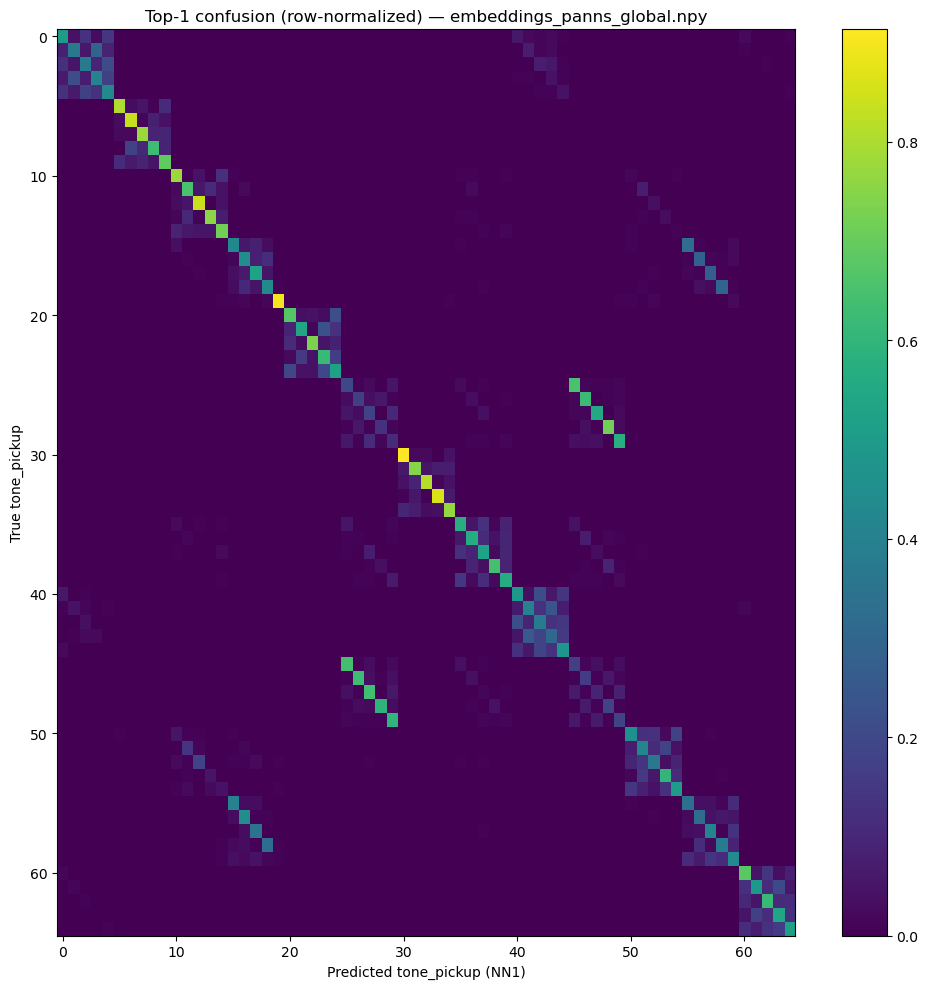

Saved: outputs_01_panns_base_egfxset/panns_confusion_top1_embeddings_panns_global.png


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Mejor embedding+pooling según evaluación (top1, luego top5)
best_row = res_df_eval.sort_values(["top1", "top5"], ascending=False).iloc[0]
best_file = best_row["file"]
best_path = OUT_DIR / best_file
print("Best:", best_file, "| top1=", float(best_row["top1"]), "top5=", float(best_row["top5"]))

# 2) Cargar embeddings (memmap)
X = np.memmap(best_path, dtype=np.float32, mode="r").reshape(len(df), -1)
assert X.shape[0] == len(df), f"X filas {X.shape[0]} != df filas {len(df)}"

# 3) Labels
y = df["tone_pickup"].astype(str).to_numpy()
classes = sorted(np.unique(y).tolist())
c2i = {c:i for i,c in enumerate(classes)}
y_idx = np.array([c2i[v] for v in y], dtype=np.int32)

# 4) Normalizar para coseno
Xn = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

# 5) NN1 por bloques (evita matriz N×N completa en RAM)
N = Xn.shape[0]
block = 1024  # puedes subir/bajar si quieres
pred_idx = np.empty(N, dtype=np.int32)

for s in range(0, N, block):
    e = min(N, s + block)
    # similitud coseno batch x N
    S = Xn[s:e] @ Xn.T
    # quitar self-match
    for i in range(s, e):
        S[i - s, i] = -np.inf
    pred_idx[s:e] = np.argmax(S, axis=1)

y_pred = y_idx[pred_idx]

# 6) Confusion matrix (row-normalized)
cm = confusion_matrix(y_idx, y_pred, labels=np.arange(len(classes)))
cm_row = cm / (cm.sum(axis=1, keepdims=True) + 1e-12)

# 7) Plot
fig = plt.figure(figsize=(10, 10))
plt.imshow(cm_row, aspect="auto")
plt.title(f"Top-1 confusion (row-normalized) — {best_file}")
plt.xlabel("Predicted tone_pickup (NN1)")
plt.ylabel("True tone_pickup")
plt.colorbar()
plt.tight_layout()
plt.show()

# 8) Guardar
savefig(fig, f"panns_confusion_top1_{Path(best_file).stem}")
plt.close(fig)
